https://github.com/atcemgil/notes/blob/master/HiddenMarkovModel.ipynb

In [1]:
%matplotlib inline
#import networkx as nx
#import pygraphviz
import pyparsing
import numpy as np
import matplotlib.pylab as plt

from IPython.display import Math

In [7]:
# An implementation of the forward backward algorithm
# For numerical stability, we calculate everything in the log domain

def normalize_exp(log_P, axis=None):
    a = np.max(log_P, keepdims=True, axis=axis)
    P = normalize(np.exp(log_P - a), axis=axis)
    return P


def normalize(A, axis=None):
    Z = np.sum(A, axis=axis,keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z

def randgen(pr, N=1): 
    L = len(pr)
    return np.random.choice(range(L), size=N, replace=True, p=pr)

def predict(A, lp):
    lstar = np.max(lp)
    return lstar + np.log(np.dot(A,np.exp(lp-lstar)))

def postdict(A, lp):
    lstar = np.max(lp)
    return lstar + np.log(np.dot(np.exp(lp-lstar), A))

def update(y, logB, lp):
    return logB[y,:] + lp

def log_sum_exp_naive(l):
    return np.log(np.sum(np.exp(l)))

def log_sum_exp(l, axis=0):
    l_star = np.max(l, axis=axis, keepdims=True)
    return l_star + np.log(np.sum(np.exp(l - l_star),axis=axis,keepdims=True)) 


In [12]:
# Generate Parameter
def do_something_magical(S, R, T):
    A = np.random.dirichlet(0.7*np.ones(S), S).T
    B = np.random.dirichlet(0.7*np.ones(R), S).T
    p = np.random.dirichlet(0.7*np.ones(S)).T

    logA = np.log(A)
    logB = np.log(B)

    # Generate Data

    x = np.zeros(T,int)
    y = np.zeros(T,int)
    for t in range(T):
        if t==0:
            x[t] = randgen(p)
        else:
            x[t] = randgen(A[:,x[t-1]])

        y[t] = randgen(B[:,x[t]])
    print "x", x
    print "y", y



    # Forward Pass

    # Python indexes starting from zero so
    # log \alpha_{k|k} will be in log_alpha[:,k-1]
    # log \alpha_{k|k-1} will be in log_alpha_pred[:,k-1]
    log_alpha  = np.zeros((S, T))
    log_alpha_pred = np.zeros((S, T))
    for k in range(T):
        if k==0:
            log_alpha_pred[:,0] = np.log(p)
        else:
            log_alpha_pred[:,k] = predict(A, log_alpha[:,k-1])

        log_alpha[:,k] = update(y[k], logB, log_alpha_pred[:,k])
    

    # Backward Pass
    log_beta  = np.zeros((S, T))
    log_beta_post = np.zeros((S, T))
    
    for k in range(T-1,-1,-1):
        if k==T-1:
            log_beta_post[:,k] = np.zeros(S)
        else:
            log_beta_post[:,k] = postdict(A, log_beta[:,k+1])

        log_beta[:,k] = update(y[k], logB, log_beta_post[:,k])

    log_gamma = log_alpha + log_beta_post

    # Correction Smoother
    # For numerical stability, we calculate everything in the log domain
    log_gamma_corr = np.zeros_like(log_alpha)
    log_gamma_corr[:,T-1] = log_alpha[:,T-1]

    for k in range(T-2,-1,-1):
        log_old_pairwise_marginal = log_alpha[:,k].reshape(1,S) + logA 
        log_old_marginal = predict(A, log_alpha[:,k])
        log_new_pairwise_marginal = log_old_pairwise_marginal + log_gamma_corr[:,k+1].reshape(S,1) - log_old_marginal.reshape(S,1)
        log_gamma_corr[:,k] = log_sum_exp(log_new_pairwise_marginal, axis=0).reshape(S)


    # Verify that result coincide

    gam = normalize_exp(log_gamma, axis=0)
    gam_corr = normalize_exp(log_gamma_corr, axis=0)

    plt.figure(figsize=(20,10))
    plt.subplot(4,1,1)
    plt.imshow(log_alpha, interpolation='nearest')
    plt.subplot(4,1,2)
    plt.imshow(log_beta, interpolation='nearest')

    plt.show()
    #print(log_gamma)
    #print(log_gamma_corr)



x [4 4 6 3 6 5 1 2 7 7]
y [2 2 1 1 0 2 1 0 2 2]


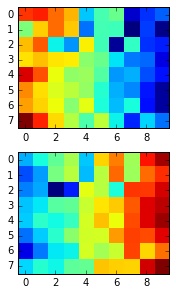

In [13]:
do_something_magical(8, 3, 10)

x [6 4 0 5 7 2 6 7 2 6 1 3 6 1 3 7 2 6 0 3]
y [2 2 1 0 2 2 2 2 0 0 1 2 0 2 0 2 0 0 1 2]


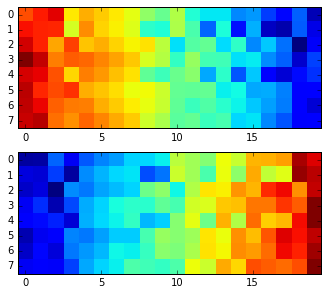

In [14]:
do_something_magical(8, 3, 20)

x [5 0 7 1 5 0 4 7 1 5 3 2 4 6 3 1 3 2 2 0 4 7 1 5 6 6 6 2 7 3 1 5 1 7 1 7 3
 1 2 5 2 2 2 0 0 4 6 5 1 5]
y [2 0 2 0 0 0 2 2 0 1 0 1 1 1 2 0 0 2 1 1 1 2 0 1 1 1 1 1 2 1 0 1 0 2 2 0 0
 0 1 0 1 1 2 1 1 1 1 1 2 0]


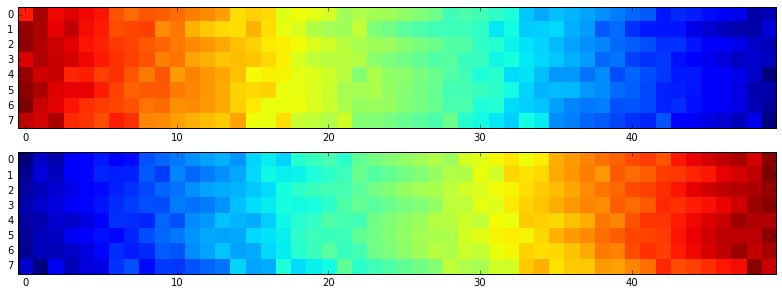

In [15]:
do_something_magical(8, 3, 50)

In [16]:
do_something_magic(8, 3, 200)

NameError: name 'do_something_magic' is not defined

In [ ]:
do_something_magical(8, 3, 20)

In [ ]:
do_something_magical(8, 400, 20)

In [ ]:
do_something_magical(8, 1000, 50)

x [2 2 3 0 7 2 4 4 4 3 6 6 3 2 2 6 5 1 3 3 6 0 0 2 3 0 2 2 3 6 3 6 3 2 6 2 5
 5 7 0 5 2 2 5 4 4 3 6 0 1]
y [8606 9528  635 8232 1145  844 8807 5267 4773 2406 6240 8733 4205 5966 4706
 5538  326 4778   24  772 6076 2448 4654 9060 7480 9705 2270 2675  664 4054
  985  343 3720 4446   19 3575 2144 2765 3655 4380 7330 9859 1695 1283 2439
 1291 7347 6525 2611 7024]


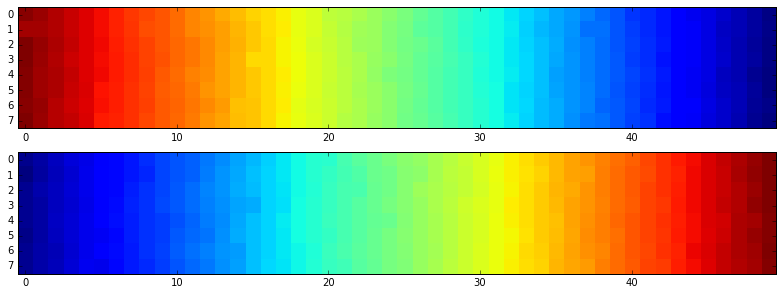

In [17]:
do_something_magical(8, 10000, 50)

x [6 9 8 4 2 9 7 8 7 8 4 5 0 1 3 6 8 4 6 8 9 7 4 2 9 3 6 1 4 4 2 2 7 8 7 8 6
 8 5 8 8 7 8 9 7 7 1 7 7 8 8 7 7 8 5 9 6 4 5 1 3 7 0 8 7 1 7 8 1 1 7 7 8 7
 9 3 5 7 8 8 7 8 5 9 3 6 6 4 7 0 3 6 5 7 8 4 4 2 9 7]
y [715 918   8 553 396 842 427 441 451 917 748 121 281 388 346 992 911 584
 532 558  94 245 319 422 971 409 768 513 936 701 279 606 243 361  71 497
 172 737  33  60  65 343 331 375 992 774  33 862 328 841 190 133 604  81
 945 599 528  74 222 423 787 219 443  10 226 328 804 919 639 245 841 316
 574 982 310 776  89 808 699 905 519 300 299 626 273 658 124 863  62 504
 676 313 617 127 193 728 901  48 999 597]


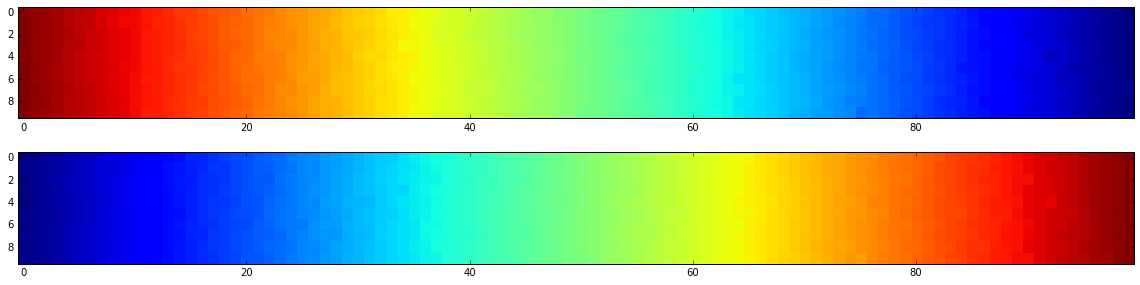

In [18]:
do_something_magical(10, 1000, 100)

x [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
y [762 842 476 662 980  81 774 868 237 604 495 767 939 335 701 109 761 660
 989  16 228 744 869 759 229 772 620  36 835 205  70 290 892 121 330 761
 379 912 650  30 823 743 137 698 435 791 751 495 120 768 786 506 987 761
 169  51 704 690 390 470 545 537 104 394 118 330 918 965 602 296 473 341
 609 325 692 541 159 811 475 806 593 561 660  55 871 782 602 747 341 241
  37 960 632 769 136 463 644 899 294 883]


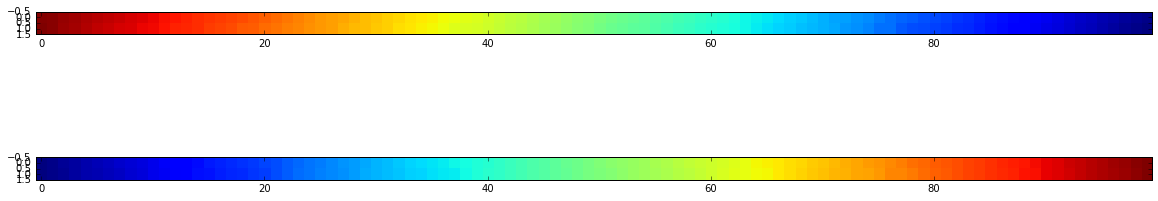

In [20]:
do_something_magical(2, 1000, 100)